# Text Generation with miniature GPT

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2020/05/29<br>
**Last modified:** 2020/05/29<br>
**Description:** Implement miniature version of GPT and learn to generate text.

## Introduction

This example demonstrates autoregressive language modelling using
a miniature version of GPT model.
The model consists of a single transformer block with causal masking
in its attention layer.
We use the text from IMDB sentiment classification dataset for training
and generate new movie reviews for a given prompt.
When using this script with your own data, make sure it has at least
1M words.

This example should be run with `tf-nightly>=2.3.0-dev20200531` or
with tensorflow 2.3 or higher.

**References:**

- [GPT](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035)
- [GPT-2](https://www.semanticscholar.org/paper/Language-Models-are-Unsupervised-Multitask-Learners-Radford-Wu/9405cc0d6169988371b2755e573cc28650d14dfe)
- [GPT-3](https://arxiv.org/abs/2005.14165)


In [1]:
!nvidia-smi

'nvidia-smi'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## Setup


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random

In [3]:
## 설치 방법
#!pip install pip install tf-nightly-gpu
import tensorflow as tf
print('TF version : %s\n'%tf.__version__)
print('Num GPUs Available : %s\n'%len(tf.config.experimental.list_physical_devices('GPU')))

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

TF version : 2.5.0-dev20201126

Num GPUs Available : 0



## Self-attention with causal masking

We compute self-attention as usual, but prevent any information to flow
from future tokens by masking the upper half of the scaled dot product matrix.


In [4]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # embedding을 head 개수로 나눠서 계산하므로 에러처리
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = \
                {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads  # 256 dimension을 8개의 head로 나눠서 계산하기 위해 head 당 dimension 계산
        self.query_dense    = layers.Dense(embed_dim)
        self.key_dense      = layers.Dense(embed_dim)
        self.value_dense    = layers.Dense(embed_dim)
        self.combine_heads  = layers.Dense(embed_dim)

    @staticmethod
    def causal_attention_mask(n_dest, n_src, dtype):
        # input : n_dest, n_src = seq_len
        # array([[[[1., 0., 0., 0.],
        #          [1., 1., 0., 0.],
        #          [1., 1., 1., 0.],
        #          [1., 1., 1., 1.]]]]       
        """
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        return tf.cast(m, dtype)  # true->1, false->2로 변형

    def attention(self, query, key, value):
        # input
        # q, k, v : (batch_size, num_heads, seq_len, projection_dim)
        # output
        # 1. output : (batch_size, seq_len, num_heads, projection_dim)
        # 2. weights
        # score : (batch_size, seq_len, seq_len) = (seq_len, embed_dim)x(seq_len, embed_dim)
        score = tf.matmul(query, key, transpose_b=True)  # (batch_size, seq_len, seq_len)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)  # embed_dim
        # scaled_score : (batch_size, seq_len, seq_len), sqrt(embed_dim)로 나눠서 normalize
        scaled_score = score / tf.math.sqrt(dim_key)  # (batch_size, seq_len, seq_len)
        
        # prevent information flow from future tokens
        shape = tf.shape(scaled_score)  # 4차원
        dim_dest, dim_src = shape[2], shape[3]
        # attention_mask
        # array([[[[1., 0., 0., 0.],
        #          [1., 1., 0., 0.],
        #          [1., 1., 1., 0.],
        #          [1., 1., 1., 1.]]]]
        attention_mask = self.causal_attention_mask(dim_dest, dim_src, scaled_score.dtype)
        attention_mask = tf.reshape(attention_mask, [1, 1, dim_dest, dim_src])  # why? 굳이?
        # 하삼각 행렬은 값을 갖고, 상삼각행렬은 -10000로 attention이 가해지지 않도록
        scaled_score = scaled_score * attention_mask - 1e4 * (1 - attention_mask)

        weights = tf.nn.softmax(scaled_score, axis=-1)  # (batch_size, num_heads, seq_len, seq_len)
        output = tf.matmul(weights, value)  # (batch_size, num_heads, seq_len, projection_dim)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        
        # q, k, v 구하기
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key   = self.key_dense(inputs)    # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        
        # multihead로 쪼개기, (batch_size, seq_len, embed_dim) -> (batch_size, num_heads, seq_len, projection_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        key   = self.separate_heads(key, batch_size)    # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        
        # q,k,v의 attention 구하기
        attention, weights = self.attention(query, key, value)  # attention : (batch_size, num_heads, seq_len, projection_dim), weight : (batch_size, num_heads, seq_len, seq_len)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, projection_dim)
        # multi-head attention을 하나로 합치기
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        # 최종 dense layer
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        
        # output : (batch_size, seq_len, embed_dim)
        return output


## Implement a Transformer block as a layer


In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        # embed_dim=512
        # num_heads=8
        # ff_dim=2048
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),  ### # (batch_size, seq_len, ff_dim)
            layers.Dense(embed_dim)  ### # (batch_size, seq_len, embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attention_output = self.att(inputs)
        attention_output = self.dropout1(attention_output)  ### # (batch_size, seq_len, embed_dim)
        out1 = self.layernorm1(inputs + attention_output)  ### # (batch_size, seq_len, embed_dim)
        ffn_output = self.ffn(out1)  ### # (batch_size, seq_len, embed_dim)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)  ### # (batch_size, seq_len, embed_dim)

## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).


In [6]:
class TokenAndPositionEmbedding(layers.Layer):
    # input : (batch_size, seq_len)
    # output: (batch_size, seq_len, embed_dim)
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # x : (batch_size, seq_len)
        maxlen = tf.shape(x)[-1]  # seq_len
        positions = tf.range(start=0, limit=maxlen, delta=1)  # [0, 1, ...seq_len]
        positions = self.pos_emb(positions)  # (seq_len, embed_dim)
        x = self.token_emb(x)  # (batch_size, seq_len, embed_dim)
        return x + positions

(1, 100, 256)


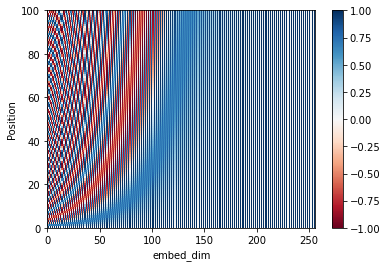

In [9]:
# transformer와 본래 positional encoding 방식
maxlen = 100
embed_dim = 256

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(maxlen, embed_dim)
print (pos_encoding.shape)

import matplotlib.pyplot as plt
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('embed_dim')
plt.xlim((0, embed_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Implement miniature GPT model


In [32]:
vocab_size = 1000  # Only consider the top 20k words, 50,257
maxlen = 100  # Max sequence size, 1024
embed_dim = 256  # Embedding size for each token, 768
num_heads = 2  # Number of attention heads, 12
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer, 1024 or 2048
num_layers = 1

# gpt3
# vocab_size = 50257  # Only consider the top 20k words, 50,257
# maxlen = 2048  # Max sequence size, 1024
# embed_dim = 12288  # Embedding size for each token, 768
# num_heads = 96  # Number of attention heads, 12
# feed_forward_dim = 12288  # Hidden layer size in feed forward network inside transformer, 1024 or 2048
# num_layers = 96

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim) # (batch_size, input_seq_len) -> (batch_size, input_seq_len, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)  # (batch_size, input_seq_len, d_model) => (batch_size, input_seq_len, d_model)
    transformer_block_list = [TransformerBlock(embed_dim, num_heads, feed_forward_dim) for _ in range(num_layers)]  # 추가,for multi-layers

#     x = transformer_block(x)
    ## 추가, multi-layers
    for i in range(num_layers):
        x = transformer_block_list[i](x)
    
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    # 훈련 데이터의 label(target)이 one-hot vector 이면 CategoricalCrossentropy
    # 훈련 데이터의 label(target)이 정수이면 SparseCategoricalCrossentropy
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

model = create_model()
model.summary()

ResourceExhaustedError: in user code:

    <ipython-input-5-89f007774850>:18 call  *
        attention_output = self.att(inputs)
    <ipython-input-4-8d4be259f347>:70 call  *
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1010 __call__  **
        self._maybe_build(inputs)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2704 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\keras\layers\core.py:1191 build
        trainable=True)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:642 add_weight
        caching_device=caching_device)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\training\tracking\base.py:810 _add_variable_with_custom_getter
        **kwargs_for_getter)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py:142 make_variable
        shape=variable_shape if variable_shape else None)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\variables.py:221 _variable_v1_call
        shape=shape)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\variables.py:199 <lambda>
        previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\variable_scope.py:2618 default_variable_creator
        shape=shape)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1585 __init__
        distribute_strategy=distribute_strategy)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1712 _init_from_args
        initial_value = initial_value()
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\keras\initializers\initializers_v2.py:410 __call__
        shape, dtype=_get_dtype(dtype), **kwargs)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\init_ops_v2.py:600 __call__
        return self._random_generator.random_uniform(shape, -limit, limit, dtype)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\init_ops_v2.py:1082 random_uniform
        shape=shape, minval=minval, maxval=maxval, dtype=dtype, seed=self.seed)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\random_ops.py:308 random_uniform
        result = math_ops.add(result * (maxval - minval), minval, name=name)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:326 add
        _ops.raise_from_not_ok_status(e, name)
    C:\Users\go\.conda\envs\venv\lib\site-packages\tensorflow\python\framework\ops.py:6868 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[12288,12288] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Add]


## Prepare data for word level language modelling

We will download IMDB data, and combine training and validation sets for
text generation task.


In [12]:
batch_size = 10

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]
for dir in directories:
    for f in os.listdir(dir)[:100]:
        filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

# Create dataset from text files
random.shuffle(filenames)
text_ds = tf.data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create vectcorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.experimental.AUTOTUNE)



400 files


## Callback for generating text


In [29]:

class TextGenerator(keras.callbacks.Callback):
    """Callback to generate text from trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for next token
    3. Sample next token and add it to the next input

    # Arguments
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
print(start_prompt,'->', start_tokens)
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)



this movie is -> [13, 16, 9]


## Train

Note: This code should preferably be run on GPU.


In [ ]:
model.fit(text_ds, verbose=2, epochs=30, callbacks=[text_gen_callback])

In [ ]:
model.load_weights("GPT_weight.h5")